# Finding Heavy Traffic Indicators on I-94

We're going to analyze a dataset about the westbound traffic on the [I-94 Interstate highway](https://en.wikipedia.org/wiki/Interstate_94).
John Hogue made the dataset available, and you can download it from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).


### Project Goal
The goal of our analysis is to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc. For instance, we may find out that the traffic is usually heavier in the summer or when it snows.

### Important informations about the dataset
The dataset documentation mentions that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data. Also, the station only records westbound traffic (cars moving from east to west).

<img src='Images/i94_figma.png'>

This means that the results of our analysis will be about the westbound traffic in the proximity of that station. In other words, we should avoid generalizing our results for the entire I-94 highway.

### 1. Lets start importing the libraries that we will use and reading our CSV file

This project will be based on two main libraries: **pandas** and **matplotlib**. In addition we will use **seaborn** (which is based in matplotlib) just to make the plots more readable.
When matplotlib is used in jupyter notebook, we need to run "%matplotlib inline" to make Jupyter able to plot our graphics.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
i94 = pd.read_csv('C:/Users/Daniel Mendes/Projects/Databases/Metro_Interstate_Traffic_Volume.csv')

### 2. Lets take a first look
Lets take a look on how our dataset was readed by pandas and at the columns structure.

In [2]:
i94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [3]:
i94.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### 2.1 First observations and columns informations

We will consolidate below what we have observed in these first exploratory impressions that we have made so far. That way, when analyzing the base in the future, we can extract as much information as is available.

| <center>Column | <center>Description | <center>Data Type Imported | <center>To do |
|---:|:---|:---:|:---:|
| `holiday` | Categorical US National holidays plus regional holiday, Minnesota State Fair | object | - |
| `temp` | Numeric Average temp in kelvin | float64 | Convert to celsius |
| `rain_1h` | Numeric Amount in mm of rain that occurred in the hour | float64 | - |
| `snow_1h` | Numeric Amount in mm of snow that occurred in the hour | float64 | - |
| `clouds_all` | Numeric Percentage of cloud cover | int64 | - |
| `weather_main` | Categorical Short textual description of the current weather | object | - |
| `weather_description` | Categorical Longer textual description of the current weather | object | - |
| `date_time` | DateTime Hour of the data collected in local CST time | object | Change from object to datetime |
| `traffic_volume` | Numeric Hourly I-94 ATR 301 reported westbound traffic volume | int64 | - |

### 3. Data cleaning

Very simple and short data cleaning in this project, because our main focus here is explore data and do analysis using visual graphics with **matplotlib** and **seaborn**.

In [4]:
i94['temp'] = (i94['temp'] - 273.15)
i94['date_time'] = pd.to_datetime(i94['date_time'])
i94.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,15.13,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,16.21,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,16.43,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,16.98,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,17.99,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### 4. Analysis

Lets start our analysis by examining the distribution of the `traffic_volume` column.

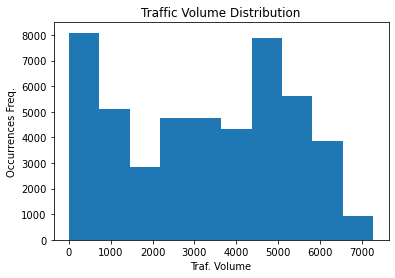

In [5]:
plt.hist(i94['traffic_volume'])
plt.title('Traffic Volume Distribution')
plt.xlabel('Traf. Volume')
plt.ylabel('Occurrences Freq.')
plt.show()

In [6]:
i94['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Between 2012-10-02 09:00:00 and 2018-09-30 23:00:00, the hourly traffic volume varied from **0** to **7,280** cars, with an average of **3,260** cars.

- About **25%** of the time, there were **1,193** cars or fewer passing the station each hour. This probably occurs during the night, or when a road is under construction.
- About **25%** of the time, the traffic volume was four times as much (**4,933** cars or more).

This possibility that nighttime and daytime might influence traffic volume gives our analysis an interesting direction: comparing daytime with nighttime data.
We'll start by dividing the dataset into two parts:

- Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
- Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

While this is not a perfect criterion for distinguishing between nighttime and daytime, it's a good starting point.

In [7]:
day = i94.copy()[(i94['date_time'].dt.hour >= 7) & (i94['date_time'].dt.hour < 19)]
print(day.shape)

night = i94.copy()[(i94['date_time'].dt.hour >= 19) | (i94['date_time'].dt.hour < 7)]
print(night.shape)

(23877, 9)
(24327, 9)


This significant difference in row numbers between day and night is due to a few hours of missing data. For instance, if you look at rows 176 and 177 (i94.iloc[176:178]), you'll notice there's no data for two hours (4 and 5).

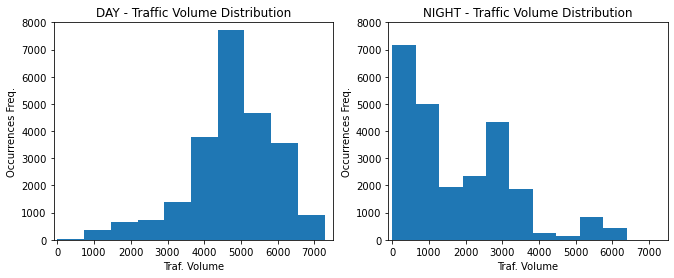

In [8]:
plt.figure(figsize=(11,4))

plt.subplot(1,2,1)
plt.hist(day['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('DAY - Traffic Volume Distribution')
plt.xlabel('Traf. Volume')
plt.ylabel('Occurrences Freq.')

plt.subplot(1,2,2)
plt.hist(night['traffic_volume'])
plt.xlim(-100, 7500)
plt.ylim(0, 8000)
plt.title('NIGHT - Traffic Volume Distribution')
plt.xlabel('Traf. Volume')
plt.ylabel('Occurrences Freq.')
plt.show()

Previously, we determined that the traffic at night is generally light. Our goal is to find indicators of heavy traffic, so we will only focus on the daytime data moving forward.

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day.

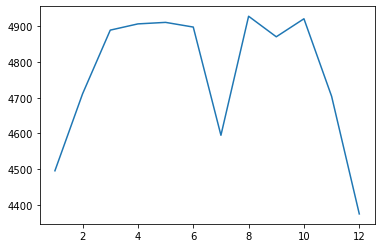

In [9]:
day['month'] = day['date_time'].dt.month
by_month = day.groupby('month').mean()
by_month['traffic_volume']

plt.plot(by_month['traffic_volume'])
plt.show()

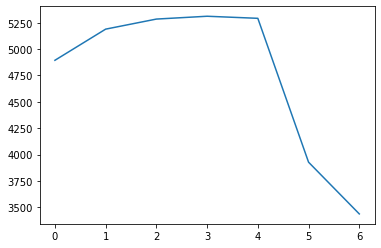

In [10]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()
by_dayofweek['traffic_volume']  # 0 is Monday, 6 is Sunday

plt.plot(by_dayofweek['traffic_volume'])
plt.show()

We found that the traffic volume is significantly heavier on business days compared to the weekends.

We'll now generate a line plot for the time of day. The weekends, however, will drag down the average values, so we're going to look at the averages separately. To do that, we'll start by splitting the data based on the day type: business day or weekend.

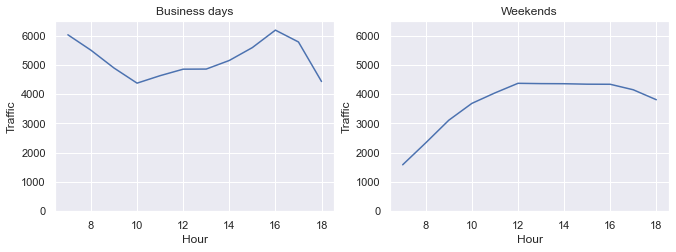

In [11]:
day['hour'] = day['date_time'].dt.hour
bussiness_days = day.copy()[day['dayofweek'] <= 4] # 4 == Friday
weekend = day.copy()[day['dayofweek'] >= 5] # 5 == Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()


sns.set_theme()
plt.figure(figsize=(11,3.5))

plt.subplot(1,2,1)
plt.plot(by_hour_business['traffic_volume'])
plt.title('Business days')
plt.xlabel('Hour')
plt.ylabel('Traffic')
plt.ylim(0,6500)

plt.subplot(1,2,2)
plt.plot(by_hour_weekend['traffic_volume'])
plt.title('Weekends')
plt.xlabel('Hour')
plt.ylabel('Traffic')
plt.ylim(0,6500)

plt.show()

So far, we've focused on finding time indicators for heavy traffic, and we reached the following conclusions:

- The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
- The traffic is usually heavier on business days compared to weekends.
- On business days, the rush hours are around 7 and 16.

Another possible indicator of heavy traffic is weather. The dataset provides us with a few useful columns about weather: `temp`, `rain_1h`, `snow_1h`, `clouds_all`, `weather_main`, `weather_description`.

A few of these columns are numerical so let's start by looking up their correlation values with `traffic_volume`.

In [12]:
print(i94.corr())

print('\n --- \n')

print(i94.corr()['traffic_volume'])

                    temp   rain_1h   snow_1h  clouds_all  traffic_volume
temp            1.000000  0.009069 -0.019755   -0.101976        0.130299
rain_1h         0.009069  1.000000 -0.000090    0.004818        0.004714
snow_1h        -0.019755 -0.000090  1.000000    0.027931        0.000733
clouds_all     -0.101976  0.004818  0.027931    1.000000        0.067054
traffic_volume  0.130299  0.004714  0.000733    0.067054        1.000000

 --- 

temp              0.130299
rain_1h           0.004714
snow_1h           0.000733
clouds_all        0.067054
traffic_volume    1.000000
Name: traffic_volume, dtype: float64


Previously, we examined the correlation between traffic_volume and the numerical weather columns. However, we didn't find any reliable indicator of heavy traffic.

To see if we can find more useful data, we'll look next at the categorical weather-related columns: `weather_main` and `weather_description`.

We're going to calculate the average traffic volume associated with each unique value in these two columns.

In [13]:
by_weather_main = day.groupby('weather_main').mean()
by_weather_description = day.groupby('weather_description').mean()

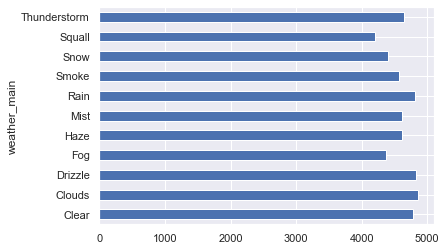

In [14]:
by_weather_main['traffic_volume'].plot.barh()
plt.show()

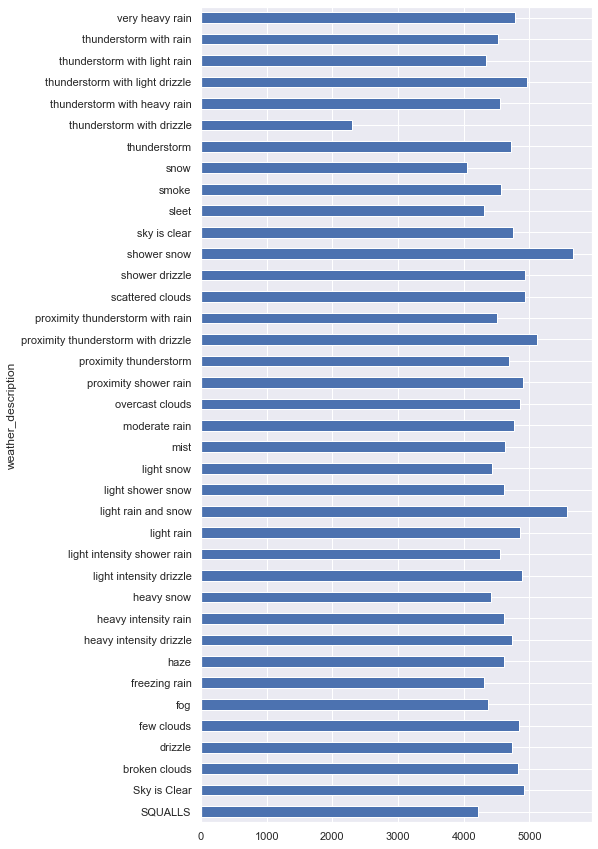

In [15]:
by_weather_description['traffic_volume'].plot.barh(figsize=(7,15))
plt.show()

It looks like there are three weather types where traffic volume exceeds 5,000:

- Shower snow
- Light rain and snow
- Proximity thunderstorm with drizzle

It's not clear why these weather types have the highest average traffic values — this is bad weather, but not that bad. Perhaps more people take their cars out of the garage when the weather is bad instead of riding a bike or walking.

### 5. Conclusion

In this project, we tried to find a few indicators of heavy traffic on the I-94 Interstate highway. We managed to find two types of indicators:

Time indicators
The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
The traffic is usually heavier on business days compared to the weekends.
On business days, the rush hours are around 7 and 16.
Weather indicators
Shower snow
Light rain and snow
Proximity thunderstorm with drizzle

### 6. Additional content

Lets use what we've discovered to plot a graphic with all major findings and main variables related to traffic in i94 using seaborn and using month as x-axis to see the relationship between month and day of week in traffic volume.

In [16]:
i94['hour'] = i94['date_time'].dt.hour
i94['day'] = i94['hour'] >= 7 & (i94['hour'] < 19)
i94['dayofweek'] = i94['date_time'].dt.dayofweek
i94['month'] = i94['date_time'].dt.month
i94['year'] = i94['date_time'].dt.year

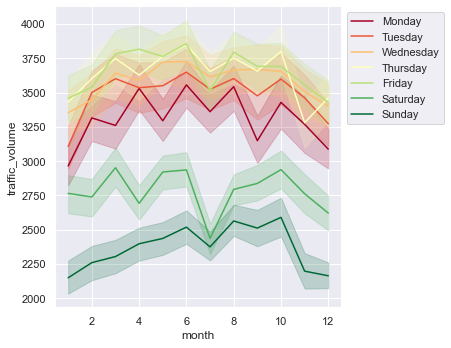

In [17]:
sns.relplot(data=i94, kind='line', x='month', y='traffic_volume', hue='dayofweek', palette='RdYlGn',legend=False)
plt.legend(labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], loc=2, bbox_to_anchor = (1,1))
plt.show()